In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.covariance import EmpiricalCovariance
from scipy.optimize import minimize
import warnings 
warnings.filterwarnings('ignore')
import pyRMT

In [67]:
# Load data 
price_data = pd.read_csv('terminal_price.csv', index_col = 0)

In [68]:
tickers = price_data.select_dtypes(include = ['float64']).columns.to_list()
num_transformers = Pipeline(steps=[('imputer',SimpleImputer(strategy='median'))])
preprocess_pipeline = ColumnTransformer(transformers=[('numerical',num_transformers, tickers)])

In [97]:
data_cleaned = preprocess_pipeline.fit_transform(price_data)
price_info = pd.DataFrame(data_cleaned, columns = price_data.columns, index = price_data.index)

In [70]:
def getData(x):
    if type(x) == str:
        return pd.Timestamp(x).date()
    else:
        x = int(x)
        return dt.date(int(str(int(x))[:4]), int(str(int(x))[4:6]), int(str(int(x))[6:]))

In [98]:
# Transform time format. 
price_info = price_info.reset_index()
price_info = price_info.rename(columns = {'index': 'time'})
price_info['time'] = price_info['time'].apply(getData)
price_info.time = pd.to_datetime(price_info['time'])
price_info = price_info.set_index('time')

In [99]:
# Get Return Data 
return_info = price_info.pct_change().fillna(0)

In [180]:
### test with few tickers 
test_ticker = return_info[['A','AA','AAPL']]

In [271]:
# Seperating training and testing dataset on rolling basis 
def rolling_backtest(data,his_win = 3, test_win = 2, shrinkage_method = 'Empirical'):
    for i in range(data.shape[0] - (his_win + test_win)):
        
        hist_data = data.iloc[i: i + his_win]
        test_data = data.iloc[i + his_win: i + his_win + test_win]
        
        if shrinkage_method == 'Empirical':
            his_cov = EmpiricalCovariance().fit(hist_data)
            his_cov = pd.DataFrame(his_cov.covariance_, index = hist_data.columns, columns = hist_data.columns)

            test_cov = EmpiricalCovariance().fit(test_data)
            test_cov = pd.DataFrame(test_cov.covariance_, index = hist_data.columns, columns = hist_data.columns)
        
        if shrinkage_method == 'Clipped':
            his_cov = pyRMT.clipped(hist_data, return_covariance = True)
            test_cov = pyRMT.clipped(test_data, return_covariance = True)
            
        if shrinkage_method == 'Optimal':
            his_cov = pyRMT.optimalShrinkage(hist_data, return_covariance = True)
            test_cov = pyRMT.optimalShrinkage(test_data, return_covariance = True)
        
        return his_cov, test_cov
his_cov, test_cov = rolling_backtest(test_ticker)


In [132]:
# Seperating training and testing dataset on rolling basis 
def rolling_backtest(data, model, his_win = 3, test_win = 2):
    for i in data.index.unique()[:(his_win + test_win + 1)]:
        hist_cov = data[(data.index >= i) & (data.index <i + pd.Timedelta(days = his_win))]
        test_cov = data[(data.index >= i + pd.Timedelta(days = his_win)) & (data.index < i + pd.Timedelta(days = his_win + test_win))]
        
        print(hist_cov)
        print(EmpiricalCovariance(hist_cov))
        #print(pyRMT.clipped(hist_cov, return_covariance = True))
        #print(pyRMT.optimalShrinkage(hist_cov, return_covariance = True))
rolling_backtest(test_ticker, EmpiricalCovariance)


              A   AA
time                
2007-09-07  0.0  0.0
                   A        AA
time                          
2007-09-10 -0.007216 -0.026460
2007-09-11  0.007075  0.005707
2007-09-12 -0.001240 -0.014770
                   A        AA
time                          
2007-09-11  0.007075  0.005707
2007-09-12 -0.001240 -0.014770
2007-09-13  0.003006  0.022710
                   A        AA
time                          
2007-09-12 -0.001240 -0.014770
2007-09-13  0.003006  0.022710
2007-09-14 -0.005472  0.006821
                   A        AA
time                          
2007-09-13  0.003006  0.022710
2007-09-14 -0.005472  0.006821
                   A        AA
time                          
2007-09-14 -0.005472  0.006821


In [256]:
# Compute strategy weights  
def weights(num, return_matrix, cov_matrix, weight_method = 'historical'):
    cov_matrix_inv = pd.DataFrame(np.linalg.pinv(cov_matrix.values), cov_matrix.columns, cov_matrix.index)
    if weight_method == 'historical':
        g_list = [1] * num
        
        w = cov_matrix_inv.dot(g_list)/np.dot(g_list.T,np.dot(r_cov,weight))
        return w/w.sum()
    
    if weight_method == 'omniscient':
        g_list = return_matrix.iloc[:-1] * n 
        
        w = cov_matrix_inv.dot(g_list)/np.dot(g_list.T,np.dot(r_cov,weight))
        return w/w.sum()
    
    if weight_method == 'random_long_short':
        g_list = np.random.uniform(0, 1, n)
        
        w = cov_matrix_inv.dot(g_list)/np.dot(g_list.T,np.dot(r_cov,weight))
        return w/w.sum()

def performance(ret, weight, weight_method = 'historical'):
    rf = 0.00
    r_mean = ret.mean() 
    p_mean = np.sum(r_mean * weight)
    if weight_method == 'historical':
       # Use Empirical Covariance Matrix
        r_cov = EmpiricalCovariance().fit(ret)
        r_cov = pd.DataFrame(r_cov.covariance_, index = ret.columns, columns = ret.columns)
    p_var = np.dot(weight.T,np.dot(r_cov,weight))
    p_std = np.sqrt(p_var)
    p_sharpe = (p_mean-rf)/p_std
    
    return p_mean,p_std,p_sharpe
    

In [233]:
np.random.seed(1)
p_mean,p_std,p_sharpe = np.column_stack([performance(test_ticker,weights(3)) for i in range(2000)])

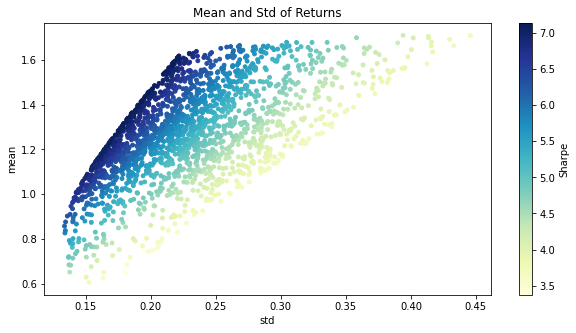

In [184]:
plt.figure(figsize = (10,5))# YlGnBu
plt.scatter(p_std, p_mean, c=p_sharpe, marker = 'o',cmap = 'YlGnBu',s = 15)
plt.xlabel('std')
plt.ylabel('mean')
plt.colorbar(label = 'Sharpe')
plt.title('Mean and Std of Returns')
plt.show()

In [228]:
def min_variance(weights, return_data):
    return performance(return_data,weights)[1]**2

In [234]:
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(3))
optv = minimize(min_variance, x0 = weights(3),args = (test_ticker,),method = 'SLSQP', bounds = bnds, constraints = cons)
optv

     fun: 0.0001863236460340026
     jac: array([0.0001883 , 0.00068315, 0.00019406])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.26636304, 0.36828042, 0.36535655])

In [235]:
result = performance(test_ticker,optv.x)
result

(0.0053597915884575666, 0.013650041979202943, 0.39265751685040146)

In [ ]:
def performance_evaluation(his_cov, test_cov):
    # Annulized out of sample average volatility 
    return ((his_cov - test_cov).std()) ** 2

In [276]:
(his_cov - test_cov).std() * 252

A       0.019994
AA      0.033773
AAPL    0.082236
dtype: float64

In [239]:
r_cov = EmpiricalCovariance().fit(test_ticker)
r_cov = pd.DataFrame(r_cov.covariance_, index = test_ticker.columns, columns = test_ticker.columns)
r_cov
# Calculate the inverse
r_cov_inv = pd.DataFrame(np.linalg.pinv(r_cov.values), r_cov.columns, r_cov.index)
#p_var = np.dot(weight.T,np.dot(r_cov,weight))

In [264]:
(r_cov - r_new).std()

A       0.0
AA      0.0
AAPL    0.0
dtype: float64

In [261]:
r_new = r_cov - 3
r_new

,A,AA,AAPL
A,-2.999916,-2.999813,-2.999992
AA,-2.999813,-2.999263,-2.999944
AAPL,-2.999992,-2.999944,-2.999797


In [251]:
g_list = [1] * r_cov_inv.shape[1]
r_cov_inv.dot(g_list)

A       21100.076171
AA      -4378.578138
AAPL     5246.930484
dtype: float64

In [245]:
test_ticker.iloc[1]

pandas.core.series.Series

In [241]:
r_cov_inv.dot(r_cov)

,A,AA,AAPL
A,1.000000e+00,-2.334072e-16,-1.562296e-15
AA,1.470994e-16,1.000000e+00,4.204441e-16
AAPL,-1.833634e-16,-2.367940e-17,1.000000e+00


In [254]:
# Implement the covariance estimator described in the exponential weighing and Random Matrix Theory. 


array([0.59005112, 0.70162054, 0.66998786])